In [470]:
import pandas as pd
import numpy as np

from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings


from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

#Libary for Autoregressive model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

#Plot PACF function
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

#Auto ARIMA for paramanter tuning
#from pmdarima.arima import auto_arima
import pmdarima as pm

#Kruskal-Wallis test
from scipy.stats import kruskal

In [471]:
#Display option to see more columns. Usefull to see all the columns of Dummy variables for Machine Learning
pd.set_option('display.max_columns', 120)

#make the charts look better for displays with retina resolution 
%config InlineBackend.figure_format = 'retina'

In [472]:
pd.set_option('display.max_rows', None)

In [473]:
#warnings.filterwarnings("ignore")

### Read in data and basic data processing

#### todo mongodb and full year

In [474]:
GoT_df = pd.read_csv('C:\\data files\\All Clean.csv')

In [475]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status
0,31,turkey_twd,yabancidizilert,mentions,fri jan 01 09:02:04 +0000 2016,682849258714886144,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,"['gameofthrones', 'supernatural', 'thewalkingd...",True
1,44,irinaforden,j0n_snow,mentions,fri jan 01 09:36:01 +0000 2016,682857802516172800,"rt @j0n_snow: you know nothing, kit harrington...","['jonsnow', 'gameofthrones']",True
2,69,fantasysite,fantasysite,tweet,fri jan 01 10:57:58 +0000 2016,682878425925746688,#gameofthrones game of thrones brienne of tart...,['gameofthrones'],False
3,113,alandalustravel,spain,mentions,fri jan 01 14:25:19 +0000 2016,682930607253499904,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...","['didyouknow', 'lawrenceofarabia', 'gameofthro...",False
4,118,rockxx1974,rockxx1974,tweet,fri jan 01 14:36:53 +0000 2016,682933518113046528,#gameofthrones marathon auf #tntserie. bitte n...,"['gameofthrones', 'tntserie']",False


In [476]:
GoT_df.isnull().sum()

Unnamed: 0        0
poster            0
recipient         4
relationship      0
tweet date        0
tweet id          0
tweet             0
hashtags          0
retweet status    0
dtype: int64

In [477]:
#convert to date and get rid of time stamp on date
GoT_df['tweet date'] = pd.to_datetime(GoT_df['tweet date'])
GoT_df['date'] = GoT_df['tweet date'].dt.date


In [478]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status,date
0,31,turkey_twd,yabancidizilert,mentions,2016-01-01 09:02:04+00:00,682849258714886144,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,"['gameofthrones', 'supernatural', 'thewalkingd...",True,2016-01-01
1,44,irinaforden,j0n_snow,mentions,2016-01-01 09:36:01+00:00,682857802516172800,"rt @j0n_snow: you know nothing, kit harrington...","['jonsnow', 'gameofthrones']",True,2016-01-01
2,69,fantasysite,fantasysite,tweet,2016-01-01 10:57:58+00:00,682878425925746688,#gameofthrones game of thrones brienne of tart...,['gameofthrones'],False,2016-01-01
3,113,alandalustravel,spain,mentions,2016-01-01 14:25:19+00:00,682930607253499904,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...","['didyouknow', 'lawrenceofarabia', 'gameofthro...",False,2016-01-01
4,118,rockxx1974,rockxx1974,tweet,2016-01-01 14:36:53+00:00,682933518113046528,#gameofthrones marathon auf #tntserie. bitte n...,"['gameofthrones', 'tntserie']",False,2016-01-01


In [479]:
missing_dates = GoT_df.copy()

#find any missing dates
missing_dates = missing_dates.set_index('date')
print(pd.date_range(start='2016-01-01', end='2016-06-30').difference(missing_dates.index))


DatetimeIndex(['2016-02-11', '2016-02-12', '2016-02-13', '2016-02-28',
               '2016-02-29', '2016-03-05', '2016-03-06', '2016-03-07',
               '2016-06-03', '2016-06-04', '2016-06-05', '2016-06-06'],
              dtype='datetime64[ns]', freq=None)


In [480]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status,date
0,31,turkey_twd,yabancidizilert,mentions,2016-01-01 09:02:04+00:00,682849258714886144,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,"['gameofthrones', 'supernatural', 'thewalkingd...",True,2016-01-01
1,44,irinaforden,j0n_snow,mentions,2016-01-01 09:36:01+00:00,682857802516172800,"rt @j0n_snow: you know nothing, kit harrington...","['jonsnow', 'gameofthrones']",True,2016-01-01
2,69,fantasysite,fantasysite,tweet,2016-01-01 10:57:58+00:00,682878425925746688,#gameofthrones game of thrones brienne of tart...,['gameofthrones'],False,2016-01-01
3,113,alandalustravel,spain,mentions,2016-01-01 14:25:19+00:00,682930607253499904,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...","['didyouknow', 'lawrenceofarabia', 'gameofthro...",False,2016-01-01
4,118,rockxx1974,rockxx1974,tweet,2016-01-01 14:36:53+00:00,682933518113046528,#gameofthrones marathon auf #tntserie. bitte n...,"['gameofthrones', 'tntserie']",False,2016-01-01


In [481]:
# Drop columns. Only interested in tweet text and date
GoT_df.drop(['Unnamed: 0','poster','recipient','relationship','tweet date','tweet id','hashtags','retweet status'], axis=1,inplace=True)

In [482]:
GoT_df.head()

,tweet,date
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01
2,#gameofthrones game of thrones brienne of tart...,2016-01-01
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01


### Basic Sentiment Analysis

In [483]:
analyzer = SentimentIntensityAnalyzer()

GoT_df['polarity'] = GoT_df['tweet'].apply(lambda x: analyzer.polarity_scores(x))
GoT_df.head()

,tweet,date,polarity
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01,"{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'comp..."
2,#gameofthrones game of thrones brienne of tart...,2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [484]:
# Change df structure to have pos, neg and neu columns
GoT_df = pd.concat(
    [GoT_df.drop(['polarity'], axis=1), 
     GoT_df['polarity'].apply(pd.Series)], axis=1)
GoT_df.head()

,tweet,date,neg,neu,pos,compound
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01,0.000,1.000,0.0,0.0000
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01,0.187,0.813,0.0,-0.4585
2,#gameofthrones game of thrones brienne of tart...,2016-01-01,0.000,1.000,0.0,0.0000
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01,0.000,1.000,0.0,0.0000
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01,0.000,1.000,0.0,0.0000


In [485]:
# Change df structure to have sentiment column
GoT_df['sentiment'] = GoT_df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
GoT_df.head()

,tweet,date,neg,neu,pos,compound,sentiment
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01,0.000,1.000,0.0,0.0000,neutral
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01,0.187,0.813,0.0,-0.4585,negative
2,#gameofthrones game of thrones brienne of tart...,2016-01-01,0.000,1.000,0.0,0.0000,neutral
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01,0.000,1.000,0.0,0.0000,neutral
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01,0.000,1.000,0.0,0.0000,neutral


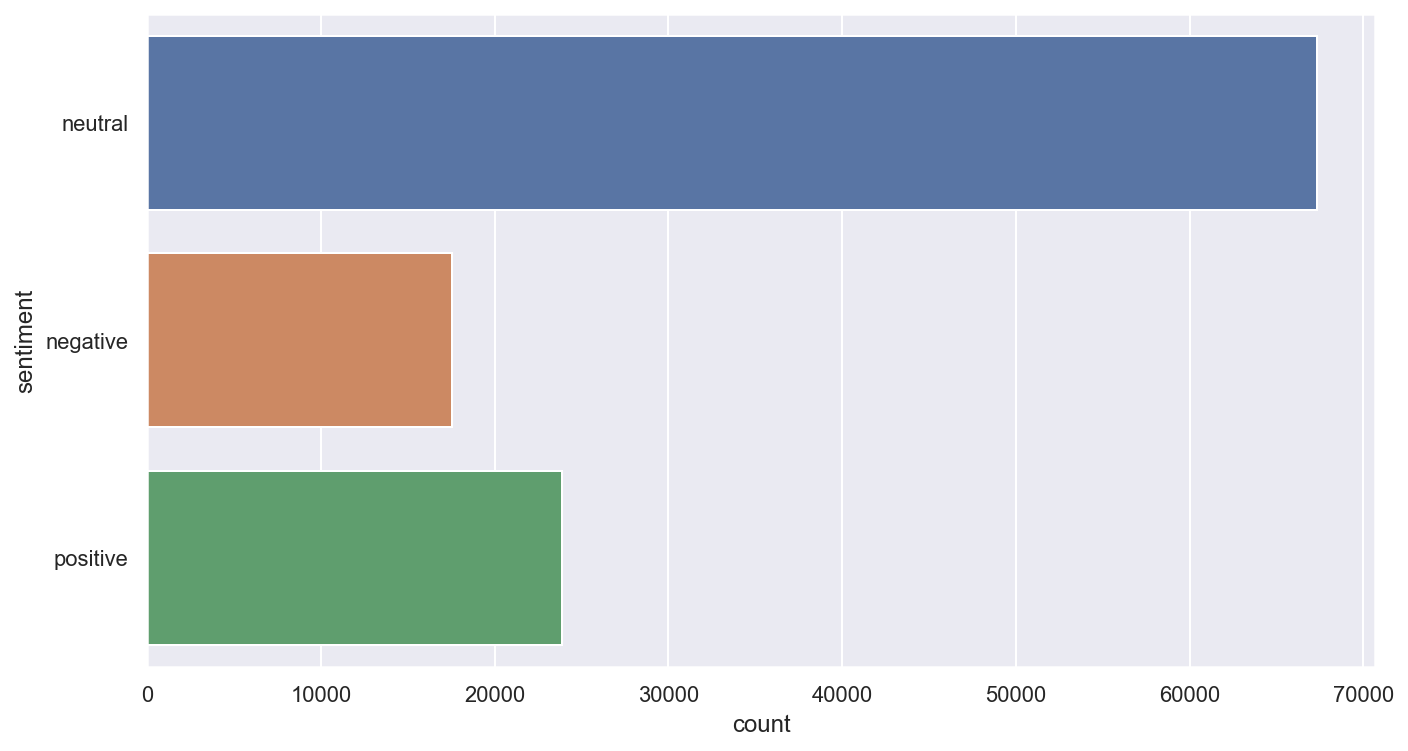

In [486]:
# Number of tweets per sentiment
sns.countplot(y='sentiment', 
             data=GoT_df, 
             );

In [487]:
#Fing how mant of each
print(GoT_df['sentiment'].value_counts()['positive'])
print(GoT_df['sentiment'].value_counts()['negative'])
print(GoT_df['sentiment'].value_counts()['neutral'])

23845
17543
67313


In [488]:
# Drop columns. Only interested in sentiment and date
GoT_df.drop(['tweet','neg','neu','pos','compound'], axis=1,inplace=True)
GoT_df.head()

,date,sentiment
0,2016-01-01,neutral
1,2016-01-01,negative
2,2016-01-01,neutral
3,2016-01-01,neutral
4,2016-01-01,neutral


In [489]:
# Get 2 dataframes for pos, neg 
# Will not be interested in neu
GoT_positive = GoT_df.loc[GoT_df['sentiment'] == 'positive']
GoT_negative = GoT_df.loc[GoT_df['sentiment'] == 'negative']

In [490]:
GoT_positive.head(91)

,date,sentiment
5,2016-01-01,positive
6,2016-01-01,positive
8,2016-01-01,positive
10,2016-01-01,positive
15,2016-01-01,positive
16,2016-01-01,positive
22,2016-01-01,positive
23,2016-01-02,positive
26,2016-01-02,positive
33,2016-01-02,positive


In [491]:
pos = GoT_positive.groupby('date', as_index=False).count()
neg = GoT_negative.groupby('date', as_index=False).count()

In [492]:
pos.shape

(171, 2)

In [493]:
pos.head(90)

,date,sentiment
0,2016-01-01,7
1,2016-01-02,20
2,2016-01-03,10
3,2016-01-04,9
4,2016-01-05,3
5,2016-01-06,18
6,2016-01-07,12
7,2016-01-08,18
8,2016-01-09,13
9,2016-01-10,4


#### Missing Data

In [494]:
pos.loc[62.5] = ['2016-06-03', 64]
pos.loc[62.6] = ['2016-06-04', 77]
pos.loc[62.7] = ['2016-06-05', 125]
pos.loc[62.8] = ['2016-06-06', 732]
pos = pos.sort_index().reset_index(drop=True)

In [495]:
pos.at[77, 'sentiment'] = 54

In [496]:
pos.shape

(175, 2)

In [497]:
pos.head(92)

,date,sentiment
0,2016-01-01,7
1,2016-01-02,20
2,2016-01-03,10
3,2016-01-04,9
4,2016-01-05,3
5,2016-01-06,18
6,2016-01-07,12
7,2016-01-08,18
8,2016-01-09,13
9,2016-01-10,4


In [498]:
#find any missing dates
#pos = pos.set_index('date')
#print(pd.date_range(start='2016-04-01', end='2016-06-30').difference(pos.index))
#reindex
#GoT_df = GoT_df.sort_index().reset_index(drop=True)

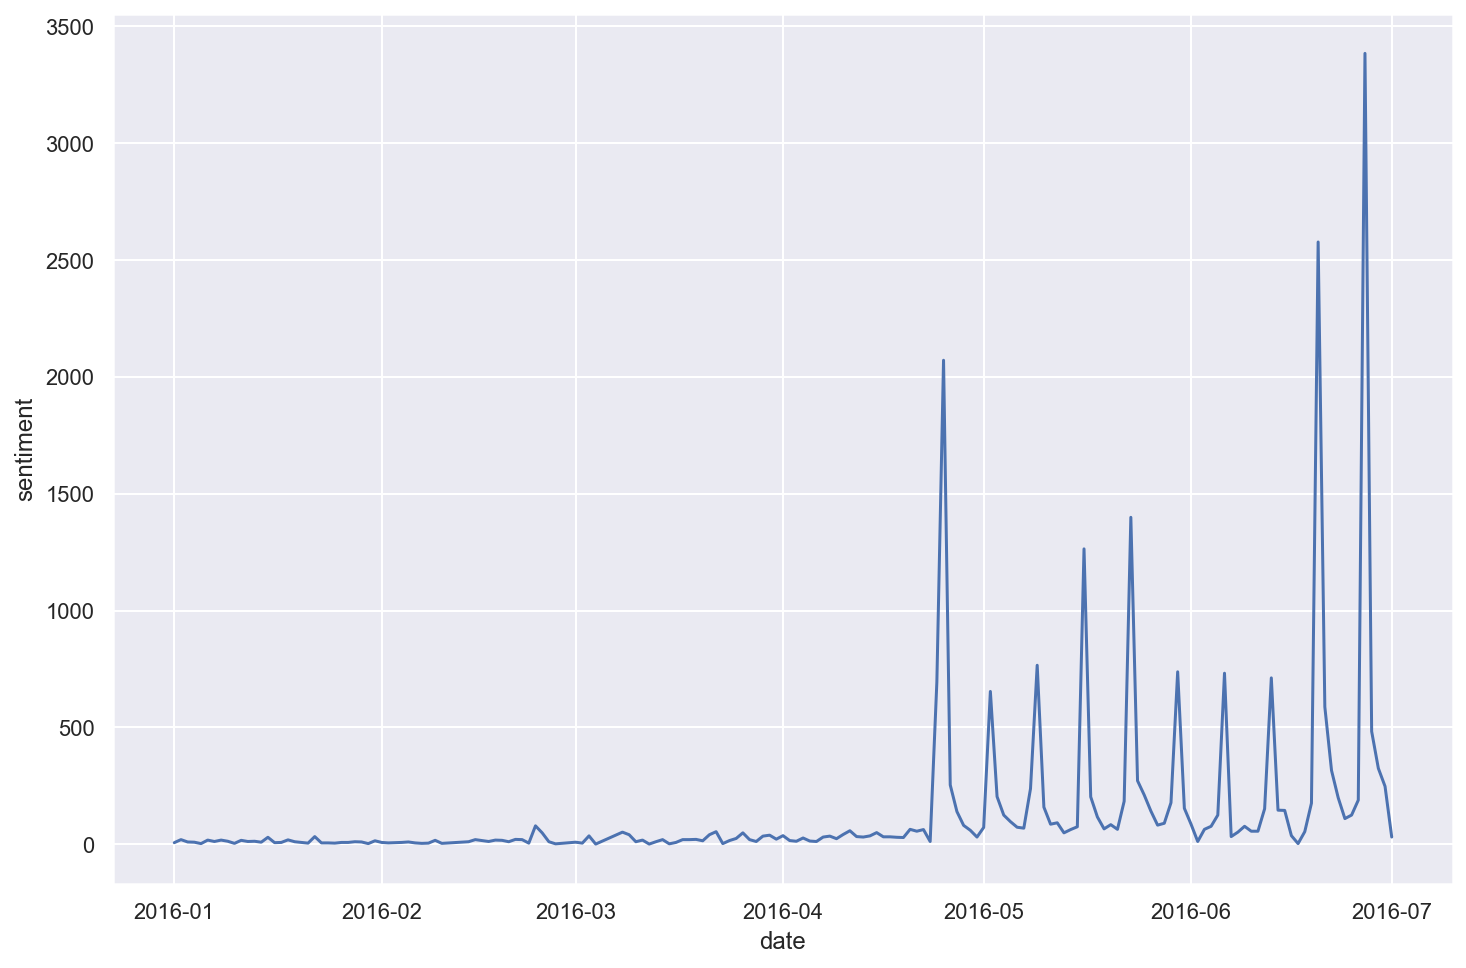

In [499]:
#Graph of positive sentiment over time

sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale=1)
myfig = sns.lineplot(x = 'date', y = 'sentiment', data = pos)
plt.show()

### Time Series

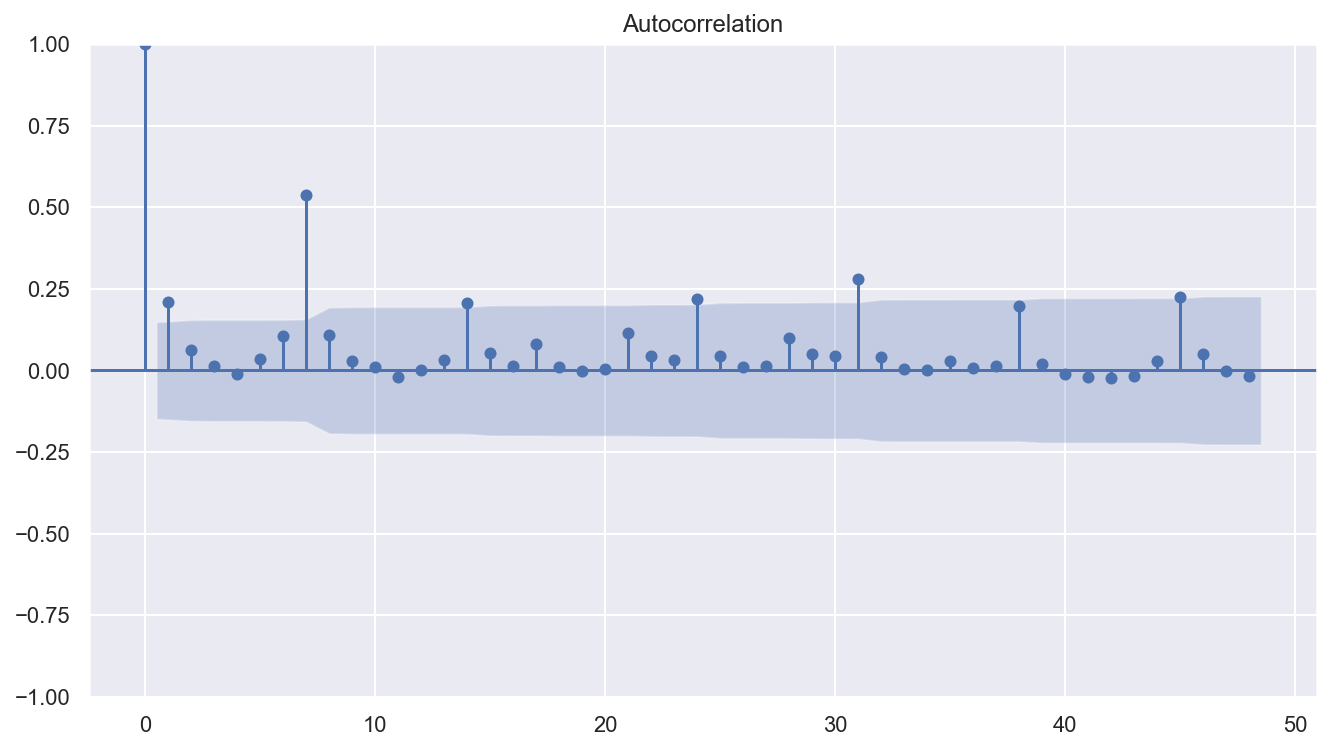

In [500]:
#Plot of Partial Autocorrelation for Positive sentiment
sns.set(rc = {'figure.figsize':(11,6)})
sns.set(font_scale=1)
acf_plot = plot_acf(pos['sentiment'], lags =48)

C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


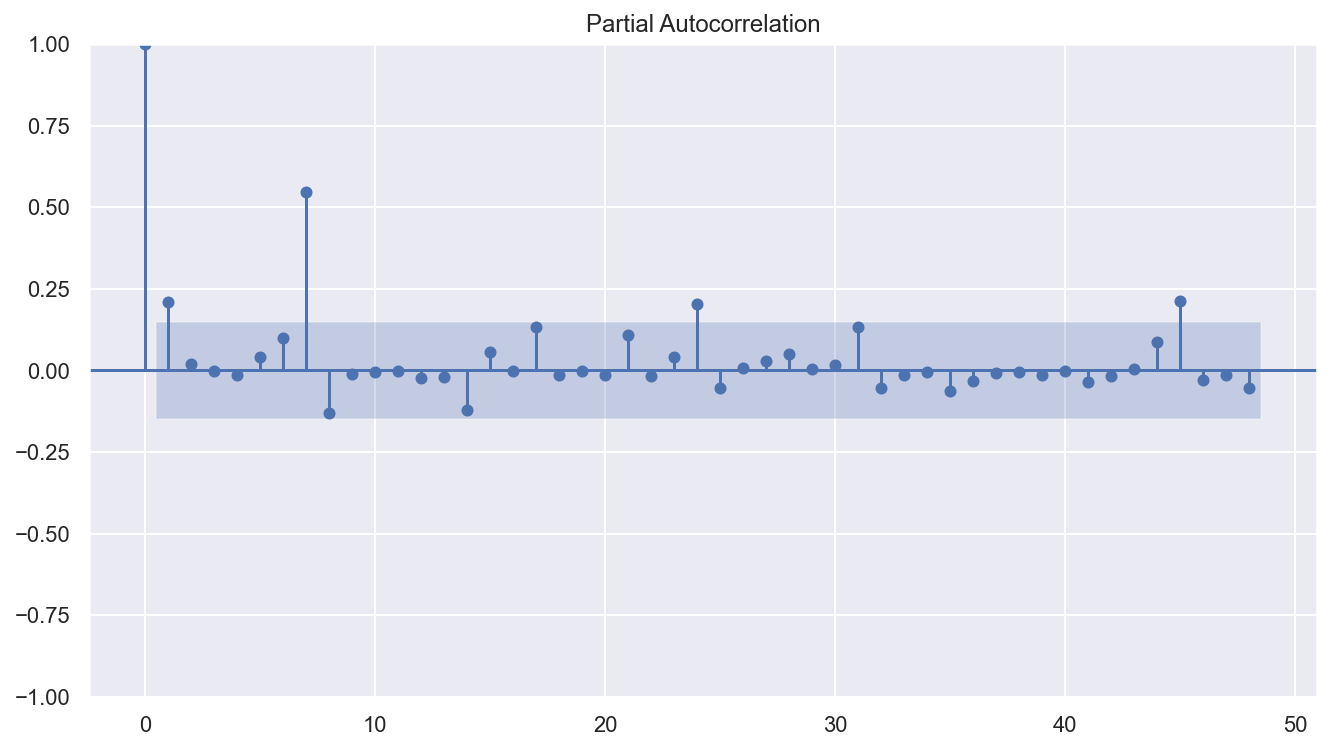

In [501]:
#Plot of Partial Autocorrelation for Positive sentiment
sns.set(rc = {'figure.figsize':(11,6)})
sns.set(font_scale=1)
acf_plot = plot_pacf(pos['sentiment'], lags =48)

#### Autoregression 

In [502]:
#copy pos df
autoregression = pos.copy()

#Drop date column 
autoregression.drop(['date'], axis=1,inplace=True)

#Drop July 1st for now
autoregression= autoregression.drop(labels=[91], axis=0)
autoregression.tail()

,sentiment
170,3384
171,483
172,325
173,248
174,31


In [503]:
#Set the size of the training data and test data. 
train = autoregression[0:70]
test = autoregression[71:91]

In [504]:
#Convert dataframes to a series  
train = train.squeeze()
test = test.squeeze()

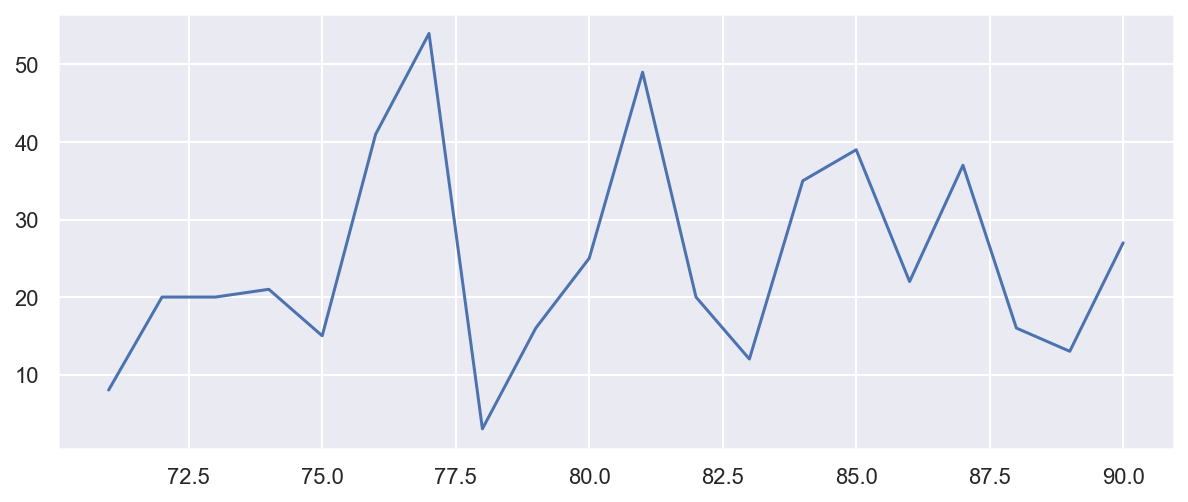

In [505]:
#Plot the test data pattern
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(test)

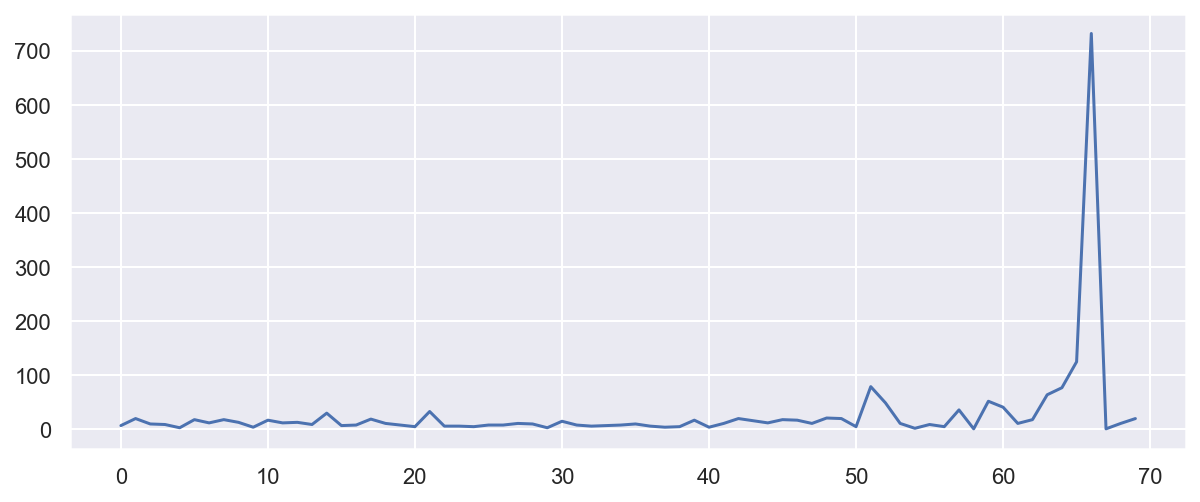

In [506]:
#Plot the training data pattern
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(train)

In [507]:
#Run the AutoReg function with 7 lags
model = AutoReg(train, 7)

#Estimate the model parameters 
modelFit = model.fit()

#Print Model Results
print(modelFit.summary())



                            AutoReg Model Results                             
Dep. Variable:              sentiment   No. Observations:                   70
Model:                     AutoReg(7)   Log Likelihood                -366.888
Method:               Conditional MLE   S.D. of innovations             81.833
Date:                Wed, 10 May 2023   AIC                            751.776
Time:                        16:01:38   BIC                            771.064
Sample:                             7   HQIC                           759.362
                                   70                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.0842     20.994     -0.814      0.416     -58.231      24.062
sentiment.L1     0.0446      0.125      0.356      0.722      -0.201       0.290
sentiment.L2     0.1065      0.129      0.82

In [508]:
#Examine accuracy of model
#Set parameters for start and end predictions
predictionStart = test.index[0]
predictionEnd = test.index[-1]

#Call the model to make predictions
predictions = modelFit.predict(start=predictionStart, end=predictionEnd)

#Difference between test and predictions
residuals = test - predictions

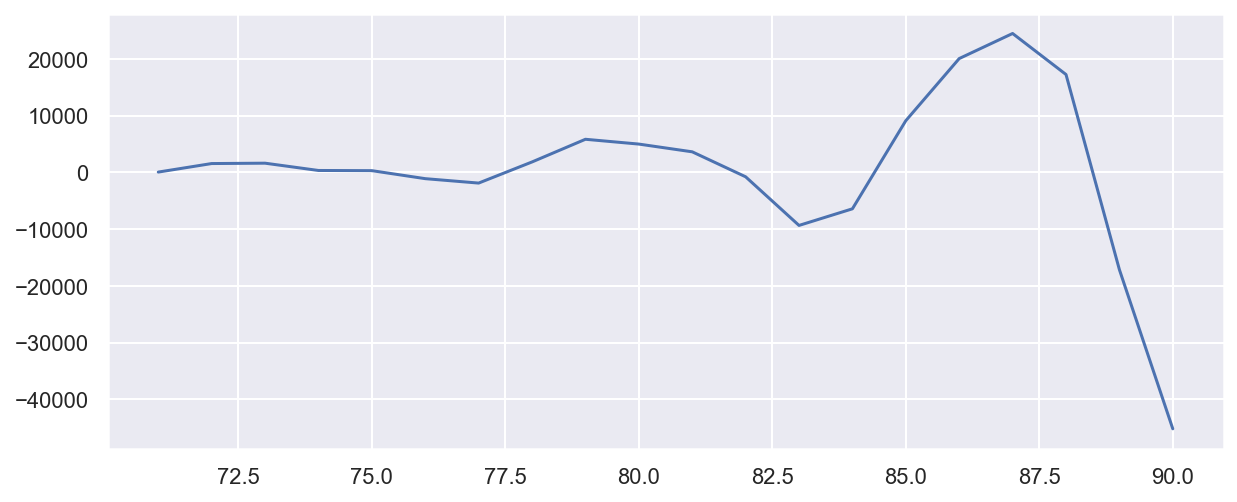

In [509]:
#Plot the pattern of the predictions
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(predictions)

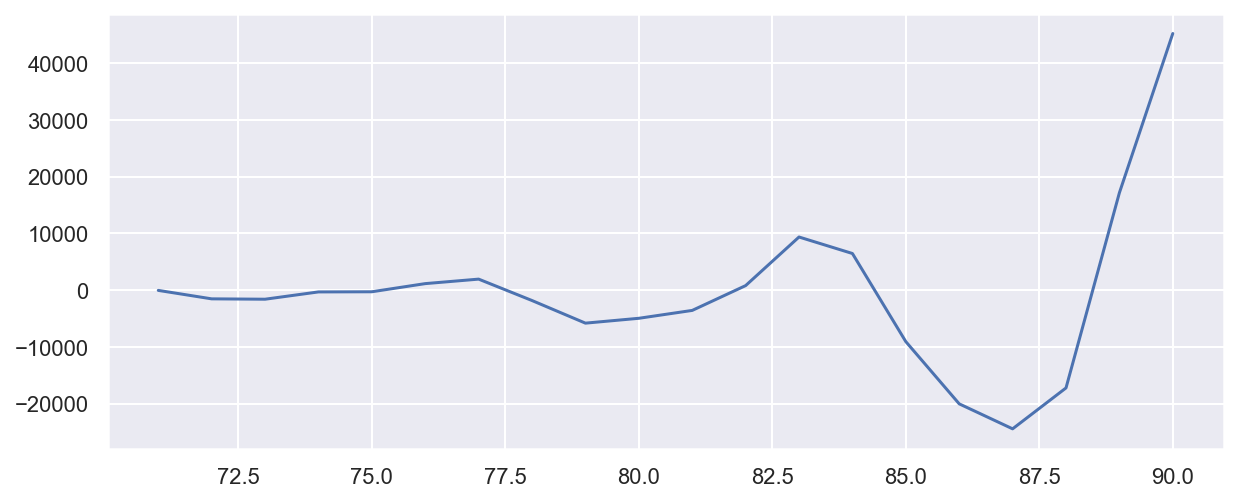

In [510]:
#Plot the pattern of the residuals
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(residuals)

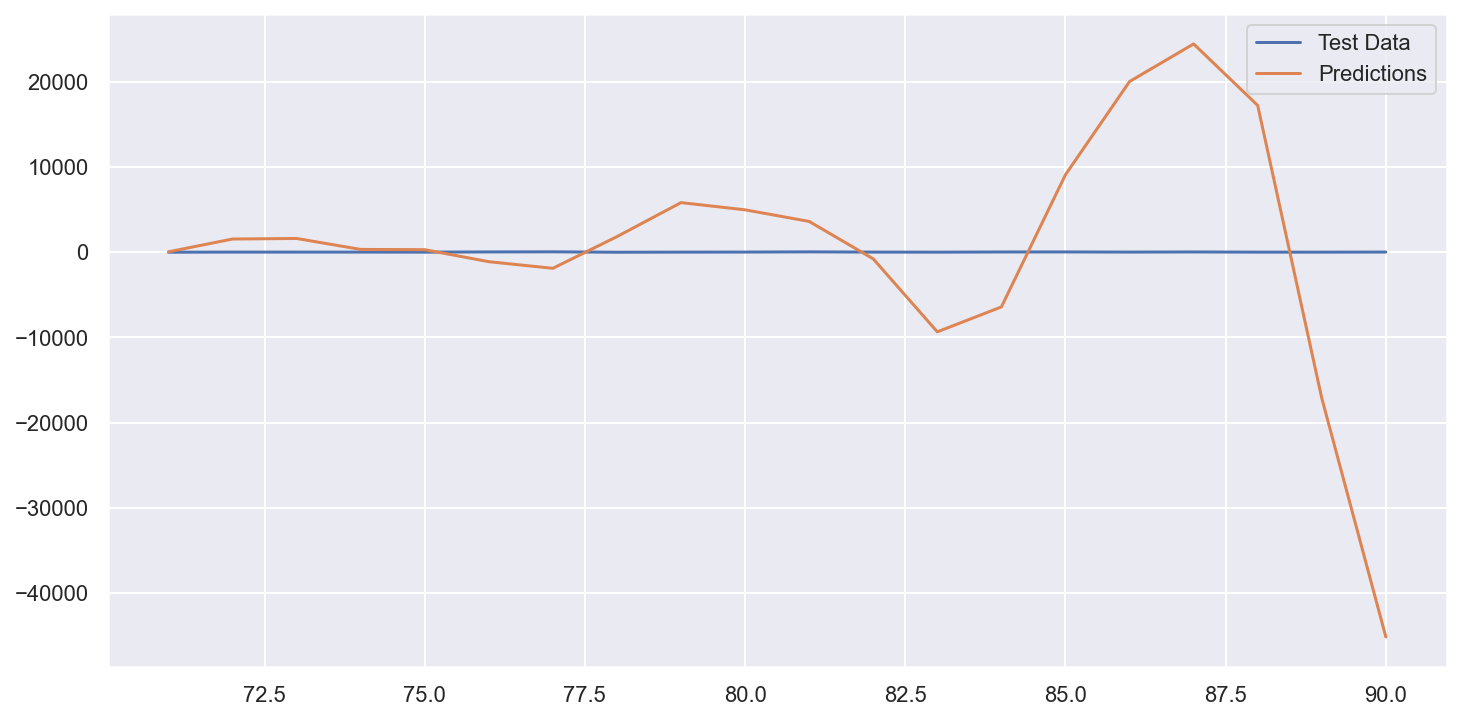

In [511]:
#Plot the graph of the Test Data vs Predictions 
plt.figure(figsize=(12,6))
#sns.set(font_scale=1)

plt.plot(test)
plt.plot(predictions)
plt.legend(('Test Data','Predictions'))

In [512]:
#Calculate Root Mean Squared error
print(f'Root Mean Squared error is: {round(np.sqrt(np.mean(residuals**2)),2)}')

Root Mean Squared error is: 14018.15


### Auto ARMA paramaters

In [513]:
#copy pos df
paramaters = pos.copy()

#Drop date column 
paramaters.drop(['date'], axis=1,inplace=True)

#Drop July 1st for now
paramaters = paramaters.drop(labels=[91], axis=0)

#Set the size of the training data and test data. 
train = autoregression[0:70]
test = autoregression[71:91]

#Convert dataframes to a series  
train = train.squeeze()
test = test.squeeze()

In [514]:
model = pm.auto_arima(train, trace=True, max_d = 7, max_q = 7, max_p=7, stepwise = False, max_order = 40 ,error_action='ignore', suppress_warnings=True)
modelFit = model.fit(train)

#Print Model Results
print(modelFit.summary())

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=828.265, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=829.190, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=830.998, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=832.789, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=829.082, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=830.847, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=832.737, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=834.720, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,7)(0,0,0)[1] intercept   : AIC=inf, Time=0

#### ARIMA

In [515]:
#copy pos df
arima = pos.copy()

#Drop date column 
arima.drop(['date'], axis=1,inplace=True)

#Drop July 1st for now
arima = arima.drop(labels=[91], axis=0)


#Set the size of the training data and test data. 
train = arima[0:70]
test = arima[71:91]

#Convert dataframes to a series  
train = train.squeeze()
test = test.squeeze()

In [516]:
model = ARIMA(train, order=(2,1,4))


#Estimate the model parameters 
modelFit = model.fit()

#Print Model Results
print(modelFit.summary())


C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                   70
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -405.436
Date:                Wed, 10 May 2023   AIC                            824.871
Time:                        16:01:52   BIC                            840.510
Sample:                             0   HQIC                           831.076
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7115      1.467     -0.485      0.628      -3.587       2.164
ar.L2         -0.2776      1.375     -0.202      0.840      -2.973       2.418
ma.L1         -0.0835     14.515     -0.006      0.9

In [517]:
#Examine accuracy of model
#Set parameters for start and end predictions
predictionStart = test.index[0]
predictionEnd = test.index[-1]

#Call the model to make predictions
predictions = modelFit.predict(start=predictionStart, end=predictionEnd)

#Difference between test and predictions
residuals = test - predictions

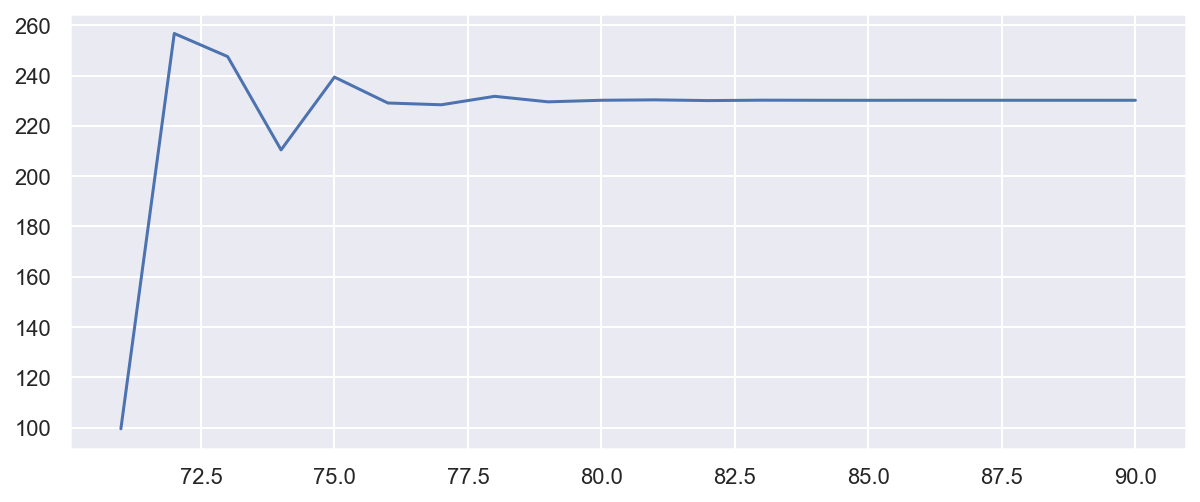

In [518]:
#Plot the pattern of the predictions
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(predictions)

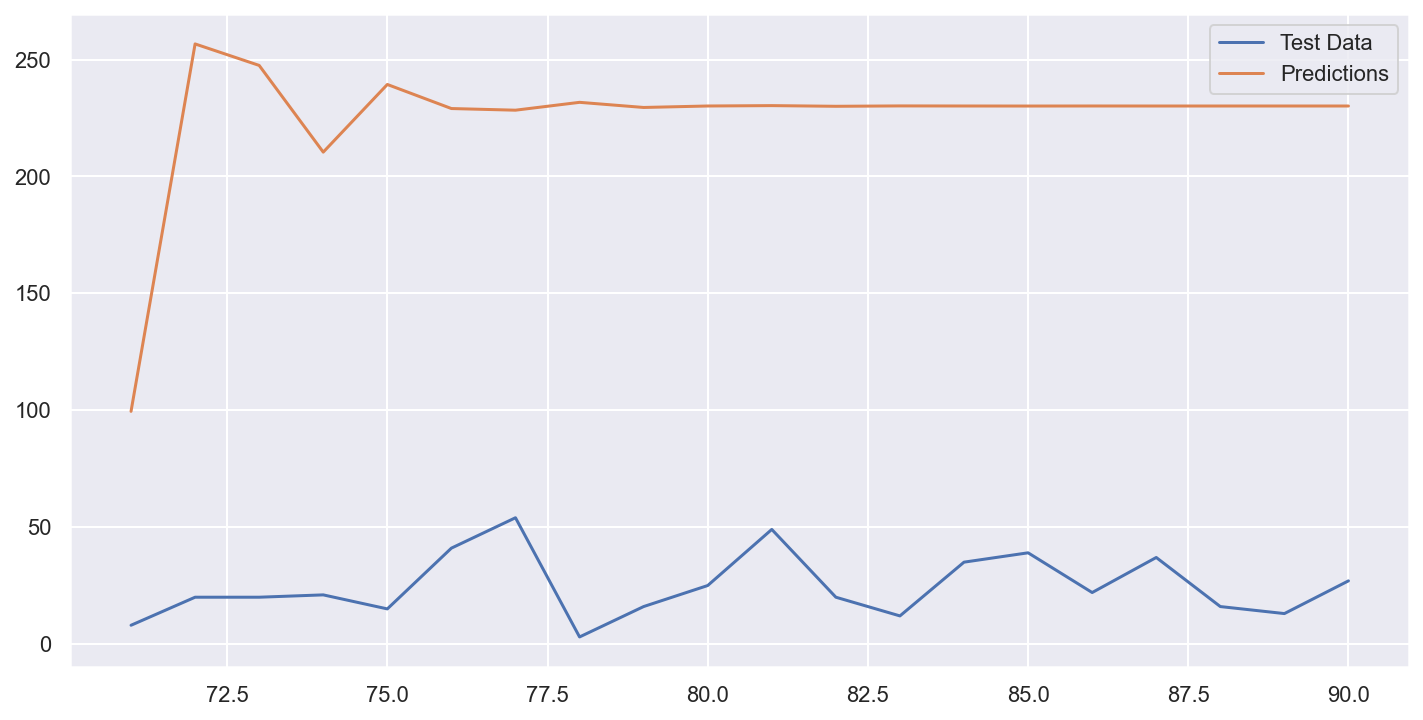

In [519]:
#Plot the graph of the Test Data vs Predictions 
plt.figure(figsize=(12,6))
#sns.set(font_scale=1)

plt.plot(test)
plt.plot(predictions)
plt.legend(('Test Data','Predictions'))

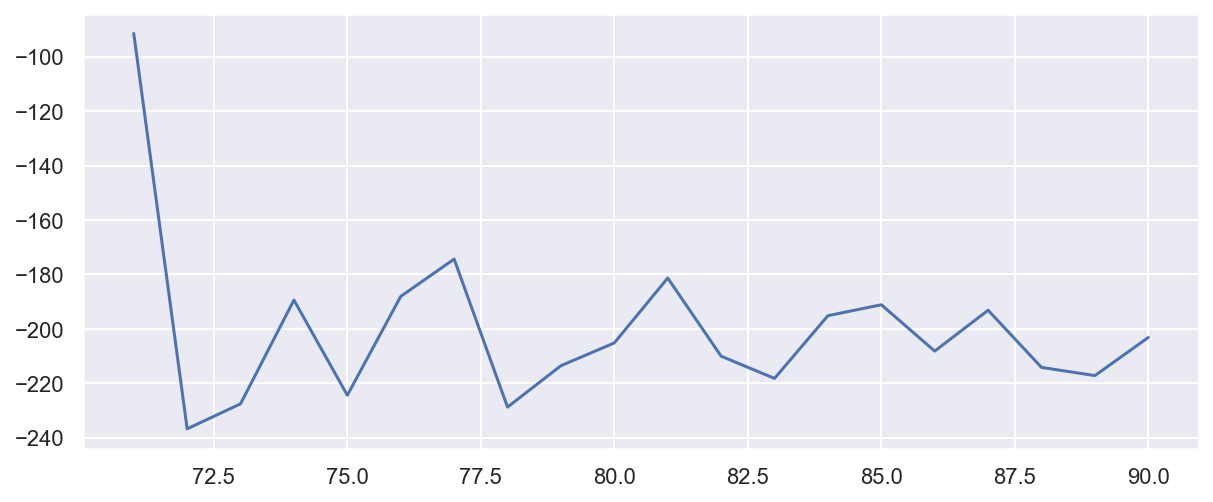

In [520]:
#Plot the pattern of the residuals
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(residuals)

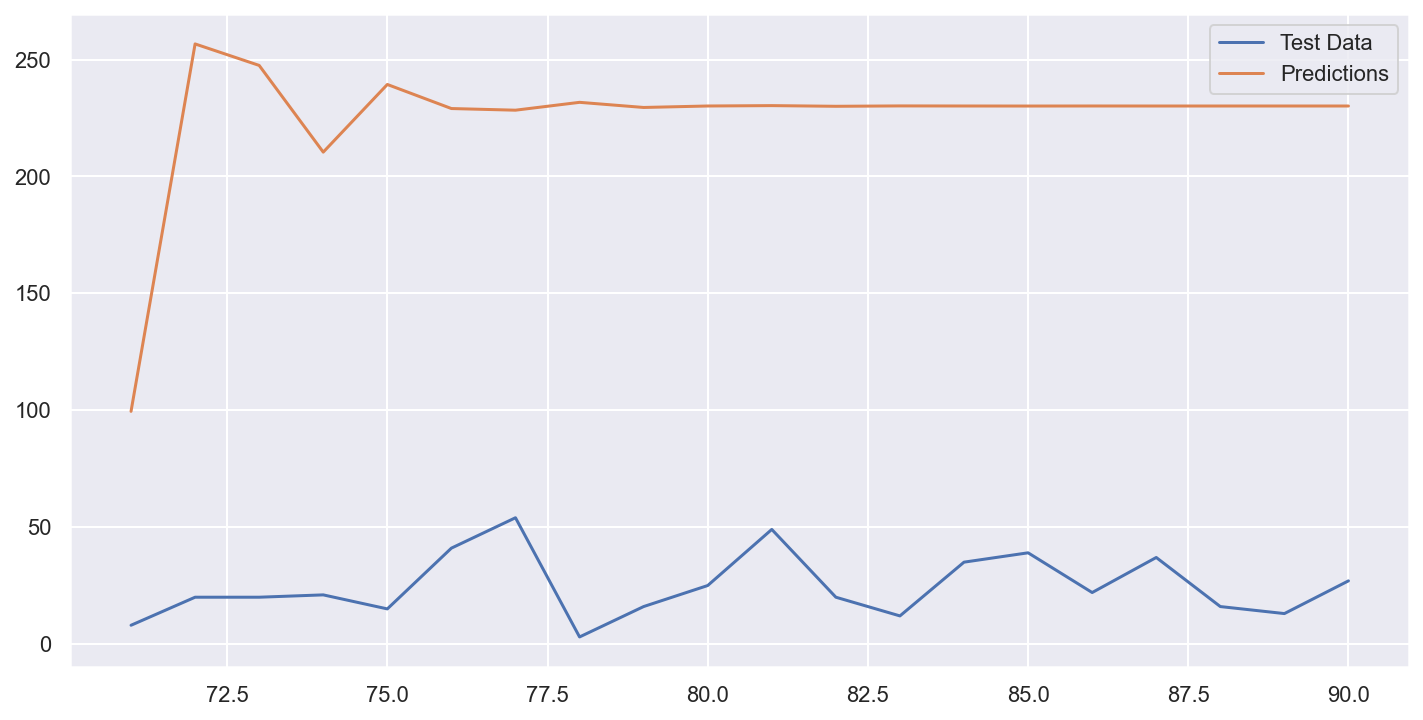

In [521]:
#Plot the graph of the Test Data vs Predictions 
plt.figure(figsize=(12,6))
#sns.set(font_scale=1)

plt.plot(test)
plt.plot(predictions)
plt.legend(('Test Data','Predictions'))

In [522]:
#Calculate Root Mean Squared error
print(f'Root Mean Squared error is: {round(np.sqrt(np.mean(residuals**2)),2)}')

Root Mean Squared error is: 202.77


### Plot

In [523]:
pos.head()

,date,sentiment
0,2016-01-01,7
1,2016-01-02,20
2,2016-01-03,10
3,2016-01-04,9
4,2016-01-05,3
